# 🧠🤖 Regressão Linear e Polinomial usando Gradient Descent

Esta é uma aula prática e o objetivo é que você exercite o uso do algoritmo de descida do gradiente (*gradient descent*) na resolução de um problema real.

Vamos usar como tarefas de exemplo os problemas de regressão linear e regressão polinomial univariadas. 

Ao longo da aula, você será conduzido a realizar as seguintes atividades: 

- Conhecer uma forma de modelar as tarefas de regressão linear e polinomial;
- Implementar modelos de regressão para cada tarefa;
- Implementar a função de perda que define o erro do modelo;
- Calcular as derivadas parciais da função de perda em relação aos parâmetros;
- Treinar os parâmetros usando descida do gradiente;
- Visualizar a evolução da função de perda ao longo do treinamento;
- Visualizar as curvas aprendidas pelos modelos;


## Fundamentação Teórica

### Definição da Tarefa

Como ilustrado nas figuras abaixo, dado um conjunto de treinamento $D = {(x_i, y_i)}$, queremos encontrar uma função $f(x)$, com parâmetros treináveis $w$, que seja uma **boa aproximação** da função que gerou os pontos. Isto é, queremos encontrar uma função capaz de **predizer o valor de y** com pequeno erro para o conjunto de treinamento e que permita **estimar** o valor de $y$ em outras posições. 

No caso de **regressão linear**, a função $f$ é uma reta e os parâmetros treináveis são o ângulo da reta e o ponto de contato com o eixo y. Isto é:

$$
f(x) = w_1 x + w_0
$$

No caso da **regressão polinomial**, a função é um polinômio e os parâmetros treináveis são os coeficientes do polinônio. 

$$
f(x) = w_0 + w_1 x^1 + w_2 x^2 + \cdots + w_d * x^d
$$

onde $d$ é o grau do polinômio escolhido pelo designer do modelo (nós). Isto é, ele é um hiperparâmetro.

🎯 **Nota**: A regressão linear é um caso especial de regressão polinomial em que o grau do polinômio é 1.

🎯 **Nota**: Como vamos lidar com funções unidimensionais e podemos plotar os gráficos para avaliar a generalização das curvas, não vamos usar um conjuto de teste hoje.

⚠️ **Importante:** Nesta aula prática, as funções verdadeiras que queremos aproximar serão conhecidas. Contudo, tenha em mente que na prática apenas os pontos são dados. Um exemplo, seria encontrar uma função que descreva a tendência de variação de ações a partir dos seus valores passados (eixo x = tempo e eixo y = valor da ação).

⚠️ **Importante:** Existem métodos mais eficientes para encontrar parâmetros de modelos de regressão linear e polinomial. O método de descida do gradiente será utilizado apenas porque é a ferramenta que será útil no nosso curso. 

linear regression

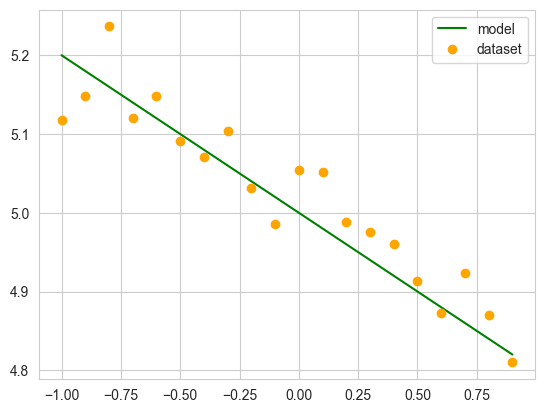


polynomial regression

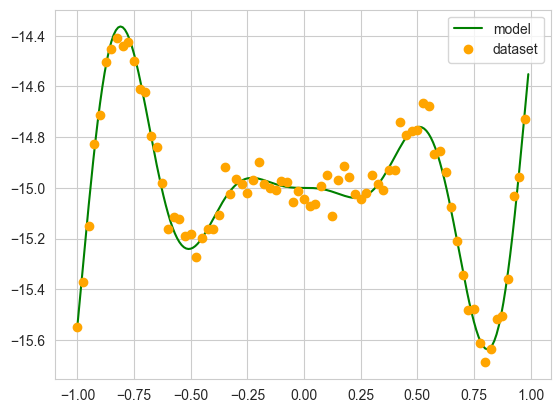

### Função de Perda

A função de perda (*loss function*) é aquela que será minimizada durante o treinamento do modelo. A função de perda mais utilizada em problemas de regressão é o erro médio quadrático (*mean squared error* - MSE). Como ilustrado na figura abaixo, primeiro usamos o modelo para predizer o valor de $y$ para cada valor de $x_i \in D$. Em seguida, calculamos a diferença entre as predições e os valores reais de $y$. O erro total do modelo será a média das diferenças ao quadrado.

Matematicamente, a função de erro $L$ para um modelo $f$ será dada por:

$$
L = \frac{1}{n} \sum_{i=1}^{n} (y_i - f(x_i))^2
$$


🎯 **Nota**: Usamos o quadrado das diferenças porque as diferenças podem ser positivas ou negativas e a função módulo (valor absoluto) não é diferenciável. 


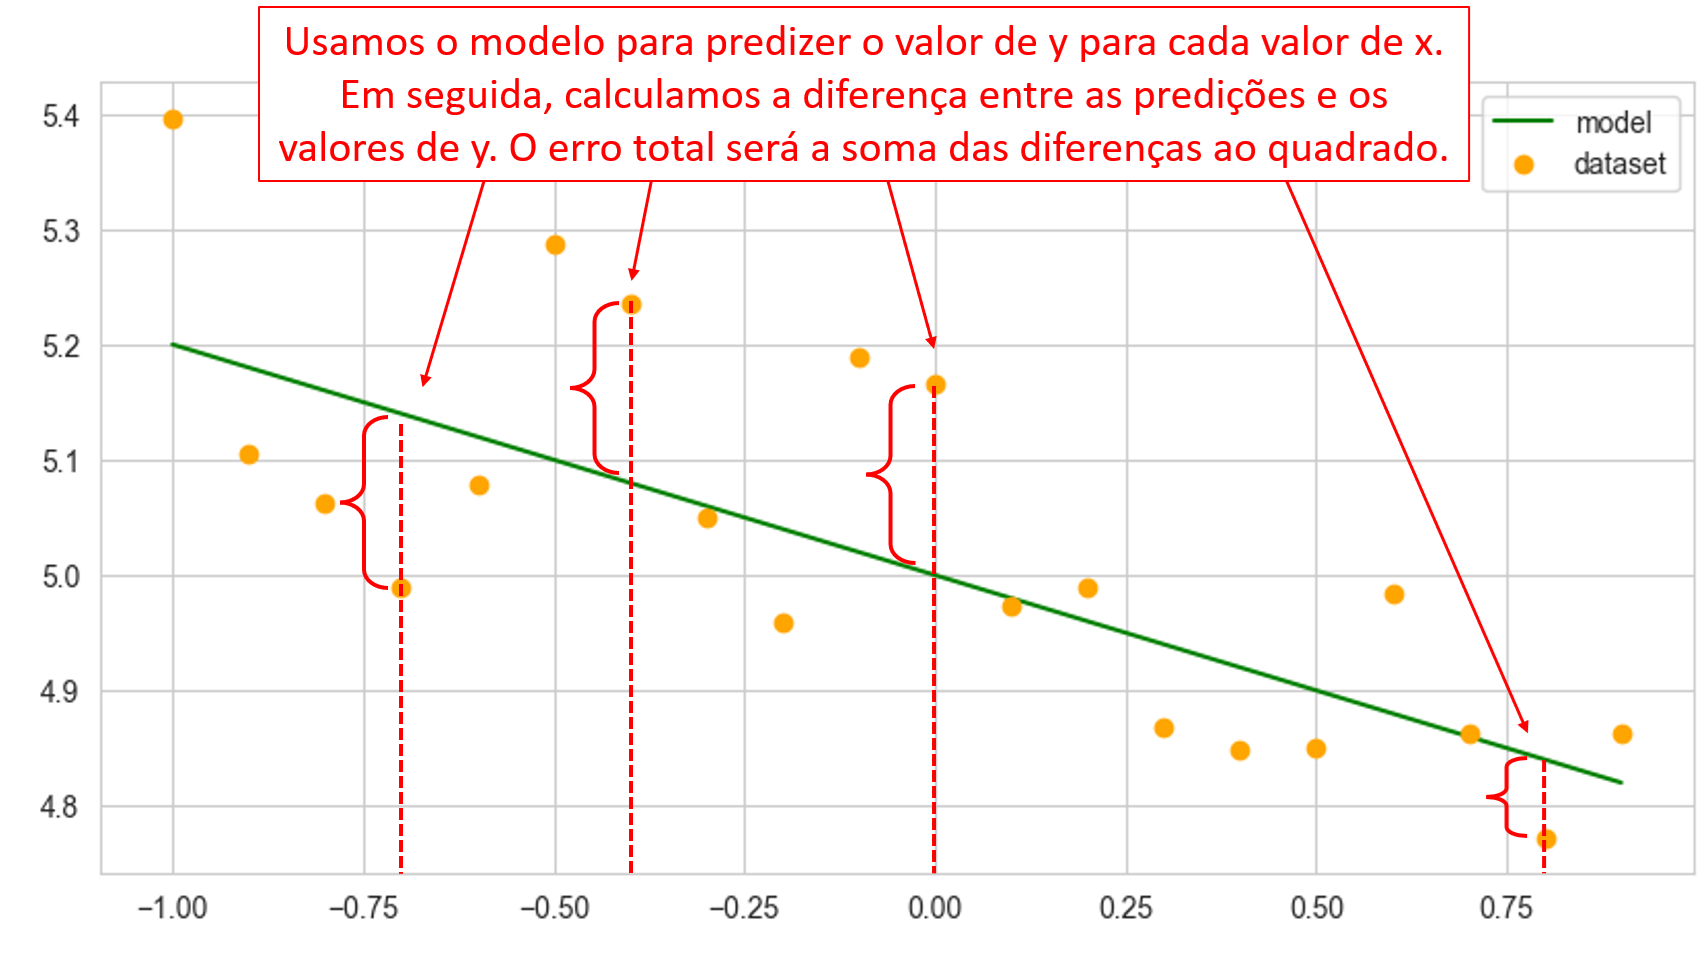

## Atividades de Implementação

### Preparação

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

A função abaixo será utilizada para criar uma dataset de pontos de exemplo. Ela recebe como entrada:

- `true_fn`: a função verdadeira usada para calcular os valores de $y$ a partir dos valores de $x$.
- `low`: limite inferior para os valores de $x$. 
- `high`: limite superior para os valores de $x$. 
- `step`: variação entre valores de $x$.
- `noise_std`: para simular ruído na captura dos pontos, vamos somar a y valores amostrados de uma distribuição normal com média zero e desvio padrão dado por esta variável.

In [2]:

def sample_points(true_fn, low=-1, high=1, step=0.1, noise_std=0.1):
    assert low < high, f'low limits ({low}) should be smaller than high ({high})'
    x = np.arange(low, high, step)
    y = true_fn(x)
    # adiciona ruido amostrado de uma distribuicao normal em y
    y += np.random.normal(size=x.shape[0], scale=noise_std)
    return x, y

A função abaixo é utilizada para plotar os pontos amostrados e, opcionalmente, a função geradora verdadeira e a função estimada pelo modelo. Ela recebe como entrada: 
- `x`: valores de $x$ do dataset
- `y` : valores de $y$ do dataset
- `true_fn`: função geradora verdadeira (opcional).
- `model_fn`: modelo usado para predizer o valor de $y$ a partir de $x$ (opcional). 
- `low`: limite inferior de $x$ para produção do gráfico.
- `high`: limite superior de $x$ para produção do gráfico.
- `step`: passo em $x$ para produção do gráfico.

🎯 **Nota:** Usamos valores inferiores, superiores e passo independentes nesta função para termos liberdade de produzir o gráfico com resolução mais fina que aquela utilizada para produzir o dataset.

In [3]:

def plot(x, y, true_fn=None, model_fn=None, low=-1, high=1, step=0.01):
    # gera intervalo de pontos no eixo x
    chart_x = np.arange(low, high, step)

    # se a funcao geradora verdadeira foi passada, ela eh usada para calcular os valores y e a curva é plotada
    if true_fn:
        plt.plot(chart_x, true_fn(chart_x), '-', color='black', label='true')

    # se o modelo foi passado, ele eh usada para calcular os valores y estimados e a curva é plotada
    if model_fn:
        model_y = [model_fn(sample_i) for sample_i in chart_x]
        plt.plot(chart_x, model_y, '-', color='green', label='model')

    # plota o dataset
    plt.plot(x, y, 'o', color='orange', label='dataset')
    plt.legend()


### Regressão Linear

Nesta tarefa, vamos criar e treinar um modelo de regressão linear univariada. Para isto, vamos realizar os seguintes passos: 
1. Produzir um dataset de exemplo.
2. Criar uma classe para representar o modelo.
3. Implementar a função de perda.
4. Calcular as derivadas parciais do erro em relação aos parâmetros.
5. Implementar o algoritmo de gradiente descendente para teste problema.
6. Treinar o modelo e analisar os resultados.

#### Geração do Dataset

A célula abaixo gera e exibe um dataset de exemplo. Veja os valores do ângulo da reta e interceptação no eixo $y$ utilizados na função verdadeira. São estes parâmetros que vamos tentar encontrar automaticamente usando o método de descida do gradiente.

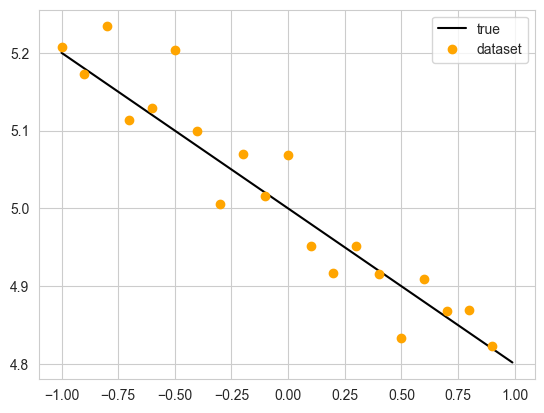

In [4]:

# funcao verdadeira
def linear_fn(x):
    return -0.2 * x + 5

# cria dataset de pontos
x, y = sample_points(linear_fn, noise_std=0.05)

# plota o dataset
plot(x, y, true_fn=linear_fn)


#### Criar uma classe para representar o modelo.

Implemente a classe `LinearRegression` para representar o nosso modelo. Ele deve implementar a seguinte função: 

$$
f(x) = x w_1 + w_0 
$$

Para isto, crie os seguintes métodos:
- `reset`: incializa os valores de $w_0$ e $w_1$ com valores aleatórios.
- `foward`: calcula o valor da função para um valor de $x$ dado.

🎯 **Nota:** Vamos criar o método `reset` ao invés de inicializar os parâmetros no construtor porque podem acontecer erros na implementação da descida do gradiente depois e precisamos de um mecanismo fácil para reinicializar o modelo e recomeçar o treinamento do zero. Sem isto, poderíamos inadvertidamente "continuar o treinamento" de um ponto ruim ao corrigir o algoritmo.

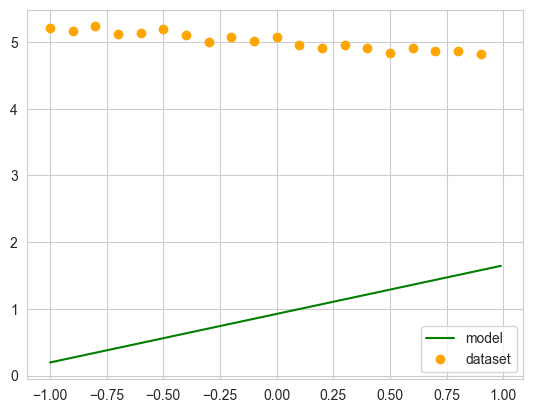

In [5]:

class LinearRegression:
    def __init__(self):
        self.reset()

    def reset(self):
        self._w0 = np.random.random()
        self._w1 = np.random.random()

    def forward(self, x):
        return self._w1 * x + self._w0

model = LinearRegression()

# 🎯 Note que podemos usar o método forward como "ponteiro de função"
plot(x, y, model_fn=model.forward)


#### Implementar a função de perda

Implemente a função MSE para calcular o erro do modelo. Vamos testar a função calculando o erro do modelo antes do treinamento. 

In [6]:

def loss_fn(x, y, model_fn):
    pred_y = [model_fn(sample) for sample in x]
    pred_y = np.array(pred_y)
    error = np.mean(np.square(pred_y - y))
    return error

loss_fn(x, y, model.forward)  # valor esperado: ~25

np.float64(17.35297260892672)

#### Calcular as derivadas parciais do erro em relação aos parâmetros

Para implementar o algoritmo de descida do gradiente, precisamos calcular a derivada do erro em relação aos parâmetros. 

Como vimos anteriormente, o erro será dado por:



$$
L = \frac{1}{N} \sum_{i=1}^n (y_i - f(x_i))^2
$$

Substituindo $f(x)$ por sua expressão:

$$
L = \frac{1}{N} \sum_{i=1}^n (y_i - (w_1 x_i + w_0))^2 
$$

Portanto:

$$
L = \frac{1}{N} \sum_{i=1}^n (y_i - w_1 x_i - w_0)^2
$$


Calcule os valores das derivadas parciais do erro em relação aos parâmetros $w_0$ e $w_1$.

$$
\frac{\partial L}{\partial w_0} \text{ e } \frac{\partial L}{\partial w_1}
$$


#### Implementar o algoritmo de gradiente descendente 

Implemente a função gd_train indicada abaixo. Ela deve realizar o número de épocas de treinamento indicado no argumento e retornar a história contendo os valores dos parâmetros e o valor da função de perda. Este valor também é exibido por época para visualizarmos o andamento do treinamento. Se o algoritmo estiver correto, a função deve decrescer ao longo das épocas. 

In [7]:

def gradient_fn(x_i, y_i, model):
    dl_df = 2 * (y_i - model.forward(x_i))
    dl_dw1 = dl_df * (-x_i)
    dl_dw0 = dl_df * (-1)
    return dl_dw1, dl_dw0

def gd_train(x, y, model, lr, n_epochs):
    history = []

    for _ in range(n_epochs):
        grad_w1 = 0
        grad_w0 = 0

        for x_i, y_i in zip(x, y):
            grad_w1_i, grad_w0_i = gradient_fn(x_i, y_i, model)
            grad_w1 += grad_w1_i
            grad_w0 += grad_w0_i

        grad_w1 /= len(x)
        grad_w0 /= len(x)

        model._w0 -= lr * grad_w0
        model._w1 -= lr * grad_w1

        loss = loss_fn(x, y, model.forward)
        history.append([model._w0, model._w1, loss])

    return history

model.reset()
history = gd_train(x, y, model, lr=3e-1, n_epochs=20)

for idx, h in enumerate(history):
    loss = h[-1]
    print(f"Epoch {idx}: {h}")

Epoch 0: [np.float64(3.392563334098355), np.float64(0.4047471685947172), np.float64(2.836565636202951)]
Epoch 1: [np.float64(4.379992847872997), np.float64(0.2322981120365368), np.float64(0.4893875272439992)]
Epoch 2: [np.float64(4.7697911816861085), np.float64(0.12413420125979006), np.float64(0.10399188029826407)]
Epoch 3: [np.float64(4.92246559788805), np.float64(0.0494051865635628), np.float64(0.034000051118386845)]
Epoch 4: [np.float64(4.98129349392794), np.float64(-0.00572306369266453), np.float64(0.017137035804447497)]
Epoch 5: [np.float64(5.003170804836209), np.float64(-0.04800569876619346), np.float64(0.010752282479551064)]
Epoch 6: [np.float64(5.010653250147311), np.float64(-0.08113320486269501), np.float64(0.00735596772211766)]
Epoch 7: [np.float64(5.012652403088857), np.float64(-0.10737760887446668), np.float64(0.005286730672840895)]
Epoch 8: [np.float64(5.012664732145122), np.float64(-0.12828691309162588), np.float64(0.003975887753827511)]
Epoch 9: [np.float64(5.01204238464

#### Treinar o modelo

A célula abaixo realiza o treinamento do modelo.

In [8]:

model.reset()
history = gd_train(x, y, model, lr=2e-1, n_epochs=20)

for idx, h in enumerate(history):
    loss = h[-1]
    print(f"Epoch {idx}: {h}")


Epoch 0: [np.float64(2.2285313606827213), np.float64(0.3815490350816273), np.float64(8.007012780111037)]
Epoch 1: [np.float64(3.351966529895141), np.float64(0.24641090779861488), np.float64(2.888574662683274)]
Epoch 2: [np.float64(4.023324868876933), np.float64(0.15184999295577473), np.float64(1.0503216700106195)]
Epoch 3: [np.float64(4.42424865396915), np.float64(0.08338740748151102), np.float64(0.3882415311206758)]
Epoch 4: [np.float64(4.663433673314996), np.float64(0.032117284162643034), np.float64(0.14836740357853379)]
Epoch 5: [np.float64(4.805919282456126), np.float64(-0.007498942244579733), np.float64(0.06040181977790793)]
Epoch 6: [np.float64(4.89061832341266), np.float64(-0.038956882130412054), np.float64(0.027356062110581662)]
Epoch 7: [np.float64(4.940808589188864), np.float64(-0.06450547725241212), np.float64(0.014363051298993823)]
Epoch 8: [np.float64(4.970411776752146), np.float64(-0.08562675531254009), np.float64(0.00883908653410847)]
Epoch 9: [np.float64(4.9877512637289

#### Analise dos resultados

A célula abaixo mostra o valor da função de perda ao longo do treinamento. Se tudo estiver correto, a função deve decrescer ao longo das épocas.

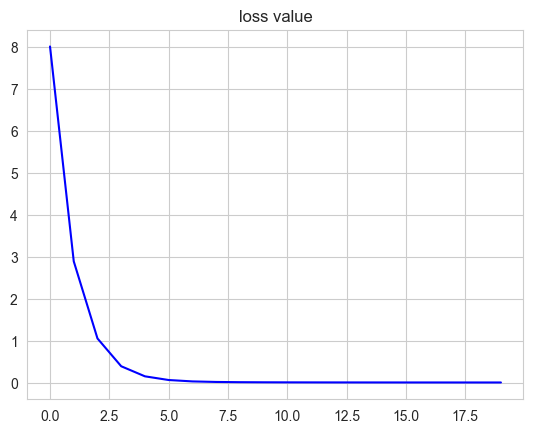

In [9]:
plt.plot([h[-1] for h in history], '-', color='blue')
plt.title('loss value')
plt.show()

A célula abaixo mostra como a curva mudou ao longo das épocas. Se tudo deu certo, a reta deve ficar no meio dos pontos.

⚠️ Veja que pode ser necessário mudar o nome dos atributos onde indicado.

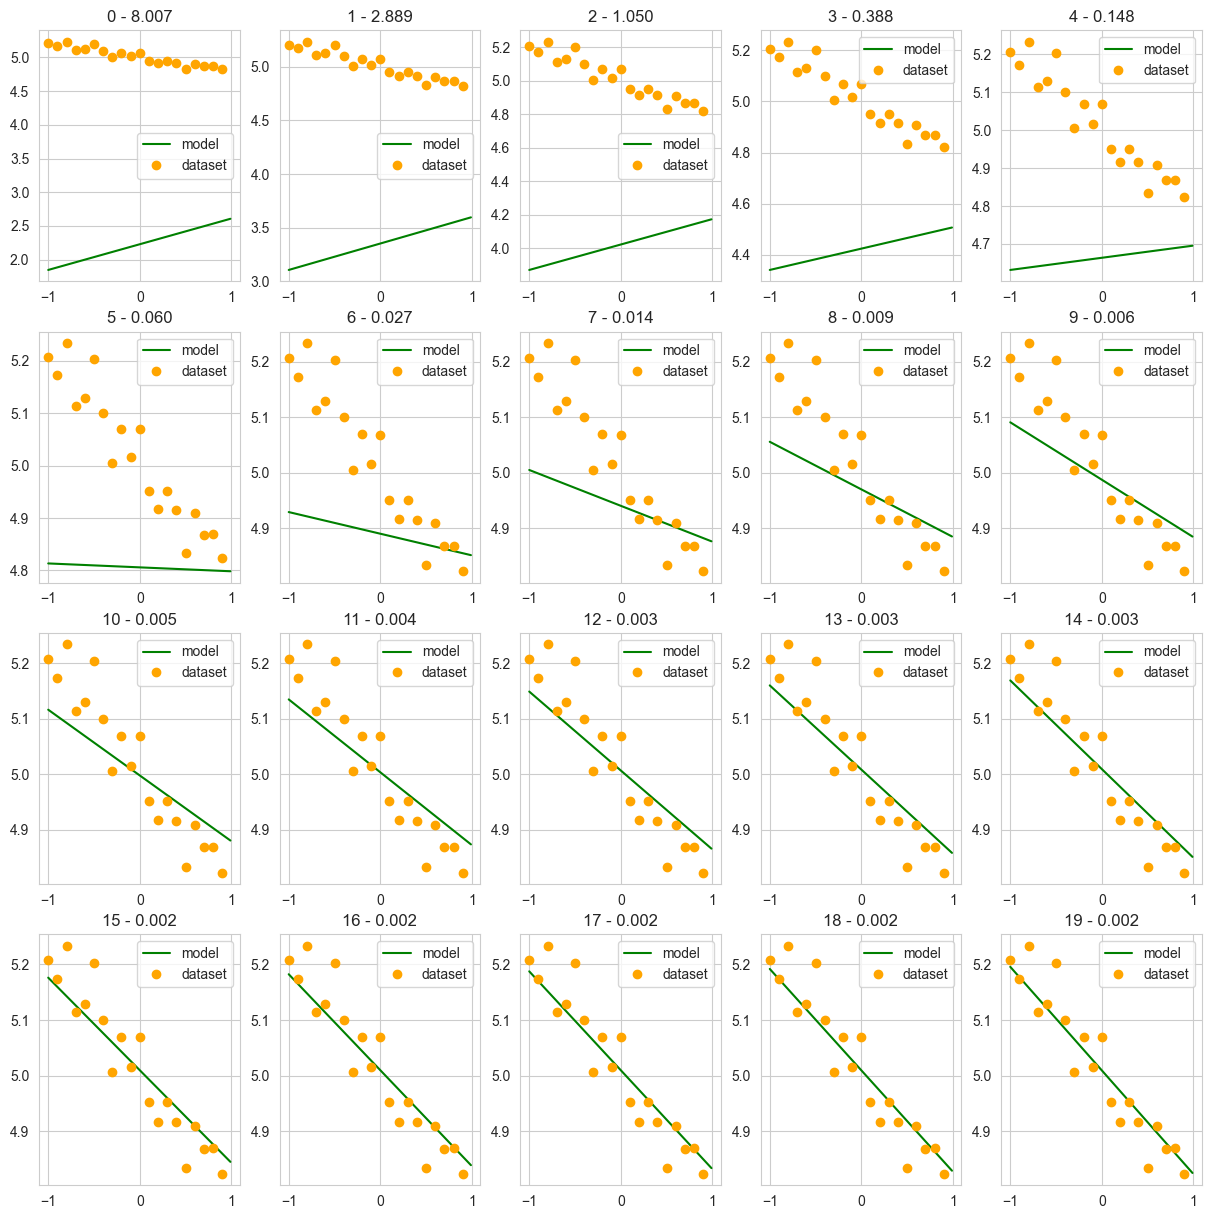

In [10]:

plt.figure(figsize=(15, 15))
for epoch, h in enumerate(history):

    # ##################################
    # Pode ser necessário mudar as linhas abaixo dependendo do nome
    # que você deu para os parâmetros.
    # ##################################
    model._w0 = h[0]
    model._w1 = h[1]

    plt.subplot(4, 5, epoch+1)
    plt.title(f"{epoch} - {h[2]:.3f}")
    plot(x, y, model_fn=model.forward)
plt.show()

### Regressão Polinomial

Nesta tarefa, vamos criar e treinar um modelo de regressão polinomial univariada. Para isto, vamos seguir os mesmos passos do exemplo anterior: 
1. Produzir um dataset de exemplo.
2. Criar uma classe para representar o modelo.
3. Implementar a função de perda.
4. Calcular as derivadas parciais do erro em relação aos parâmetros.
5. Implementar o algoritmo de gradiente descendente para teste problema.
6. Treinar o modelo e analisar os resultados.

#### Criação do Dataset

A função verdadeira neste caso não é um polinômio, mas veremos que é possível alcançar uma boa aproximação para ela mesmo assim!

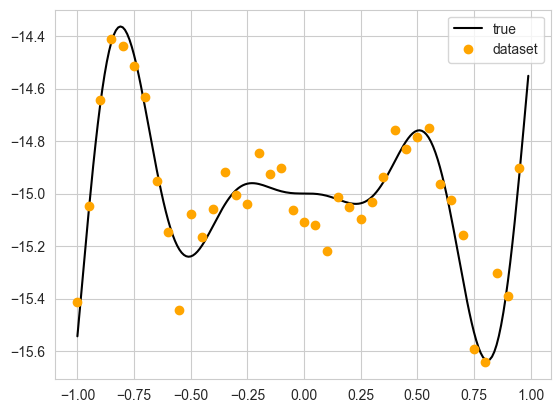

In [11]:

def poli_fn(x):
    return -x ** 2 * np.sin(x * 10) -15

x, y = sample_points(poli_fn, step=0.05)

plt.close('all')
plot(x, y, true_fn=poli_fn)
plt.show()


#### Implementação do Modelo

Crie uma classe `PolinomialRegression` com os seguintes métodos:
- `construtor`: deve receber o grau do polinômio e uma função para inicialização dos coefientes. Ao criar o objeto, podemos passar por exemplo a `np.random.randn`.
- `reset`: inicializa um array representando os coeficientes do polinômio. Note que o array deve conter $d+1$ elementos, onde $d$ é o grau do polinômio.
- `forward`: calcula o valor do polinômio dado o valor de $x$. 


Dado um valor $x_i$ o método `forward` deve implementar a seguinte função: 

$$
f(x) = w_0 + w_1 x + w_2 x^2 + \cdots + w_d x^d
$$

⚠️ **ATENÇÃO: VERIFIQUE EM TODAS AS FUNÇÕES QUE MANIPULAM COEFICIENTES DO POLINÔMIO SE OS ARRAYS POSSUEM D+1 ELEMENTOS! É MUITO COMUM ESQUECER DE USAR UM DELES!** ⚠️

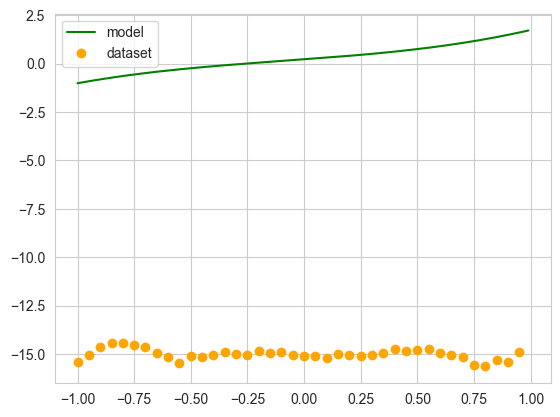

In [12]:

class PolinomialRegression:
    def __init__(self, degree, intializer_fn):
        self._degree = degree
        self._initializer_fn = intializer_fn
        self.reset()

    def reset(self):
        self._coeffs = np.array([self._initializer_fn() for _ in range(self._degree + 1)])

    def forward(self, x):
        out = 0
        for i in range(len(self._coeffs)):
            out += (self._coeffs[i] * x ** i)
        return out

# criar uma polinomio de grau 3 e mostra sua curva inicial
model = PolinomialRegression(3, np.random.random)
plot(x, y, model_fn=model.forward)


#### Função de perda

Podemos utilizar a mesma implementação da função de perda usada na regressão linear.

#### Calculo das derivadas parciais do erro em relação em relação aos coeficientes do polinômio

A função de perda é dada por: 

$$
L = \frac{1}{N} \sum_{i=1}^n (y_i - f(x_i))^2
$$

Substituindo $f(x)$ por sua expressão:

$$
L = \frac{1}{N} \sum_{i=1}^n (y_i - \sum_{k=0}^{d}(w_k x_i^k))^2 
$$

Ou, expandindo o somatório interno:

$$
L = \frac{1}{N} \sum_{i=1}^n (y_i - w_0 x_i^0 - \cdots - w_d x_i^d )^2
$$

Encontre a derivada parcial do erro em relação ao k-ésimo coeficiente: 

$$
\frac{\partial L}{\partial w_k}
$$

Note que a regra para os demais coeficientes será similar.

Observe ainda que os primeiros passos do cálculo são idênticos àquele relizado para a regressão linear.


#### Descida de gradiente e Treinamento do Modelo

Implemente a função de cálculo dos gradientes e o algoritmo de descida do gradiente de forma similar àquela feita na regressão linear.

⚠️ verifique se o array de gradientes tem o mesmo tamanho do array de coeficientes, isto é, $d+1$ elementos! ⚠️

Desta vez será necessário treinar por mais épocas para chegar em uma boa aproximação.

Brinque com o grau do polinômio e demais hiperparâmetros para tentar chegar na melhor aproximação!

100%|██████████| 20000/20000 [00:26<00:00, 742.93it/s]


Epoch 0: 150.76254847147584
Epoch 1000: 0.027800332879365362
Epoch 2000: 0.024663122217798254
Epoch 3000: 0.02366547879737573
Epoch 4000: 0.023095358118531844
Epoch 5000: 0.022687249685088687
Epoch 6000: 0.02235630546449933
Epoch 7000: 0.022066168364745436
Epoch 8000: 0.02180011834088201
Epoch 9000: 0.021550231758371313
Epoch 10000: 0.021312606009979262
Epoch 11000: 0.021085191889239092
Epoch 12000: 0.02086680392595404
Epoch 13000: 0.02065666738446169
Epoch 14000: 0.020454210188536184
Epoch 15000: 0.020258966735099325
Epoch 16000: 0.02007053289264384
Epoch 17000: 0.019888544473094162
Epoch 18000: 0.019712666518046897
Epoch 19000: 0.019542587609322353


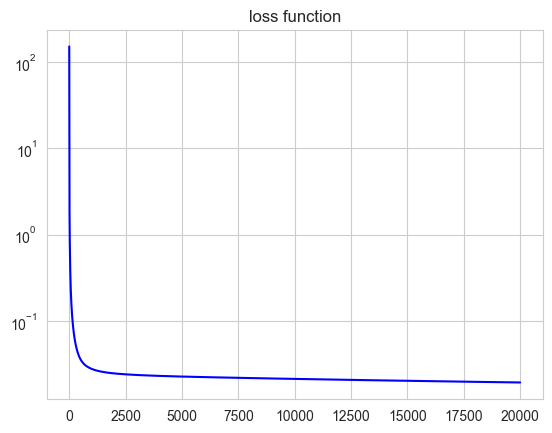

In [16]:
from tqdm import tqdm

def grad_fn(sample_x, sample_y, model):
    grads = []
    pred_y = model.forward(sample_x)
    error_grad = 2 * (sample_y - pred_y)
    for i in range(model._degree + 1):
        grads.append(error_grad * (-(sample_x**i)))
    return np.array(grads)


def gd_train(x, y, model, grad_fn, lr, n_epochs):
    history = []
    for _ in tqdm(range(n_epochs)):
        grads = np.zeros((model._degree + 1, ))

        for sample_x, sample_y in zip(x, y):
            grads += grad_fn(sample_x, sample_y, model)

        model._coeffs -= lr * (1 / len(x)) * grads

        loss = loss_fn(x, y, model.forward)
        history.append([model._coeffs.copy(), loss])

    return history

# reinicializa o modelo
model = PolinomialRegression(50, np.random.random)

# treina o modelo
history = gd_train(x, y, model, grad_fn, lr=1e-1, n_epochs=20000)

# mostra os valores da loss ao longo das epocas
for epoch in range(0, len(history), len(history) // 20):
    loss = history[epoch][-1]
    print(f"Epoch {epoch}: {loss}")

# plota a evolucao da loss
plt.plot([h[-1] for h in history], '-', color='blue')
plt.yscale('log')
plt.title('loss function')
plt.show()

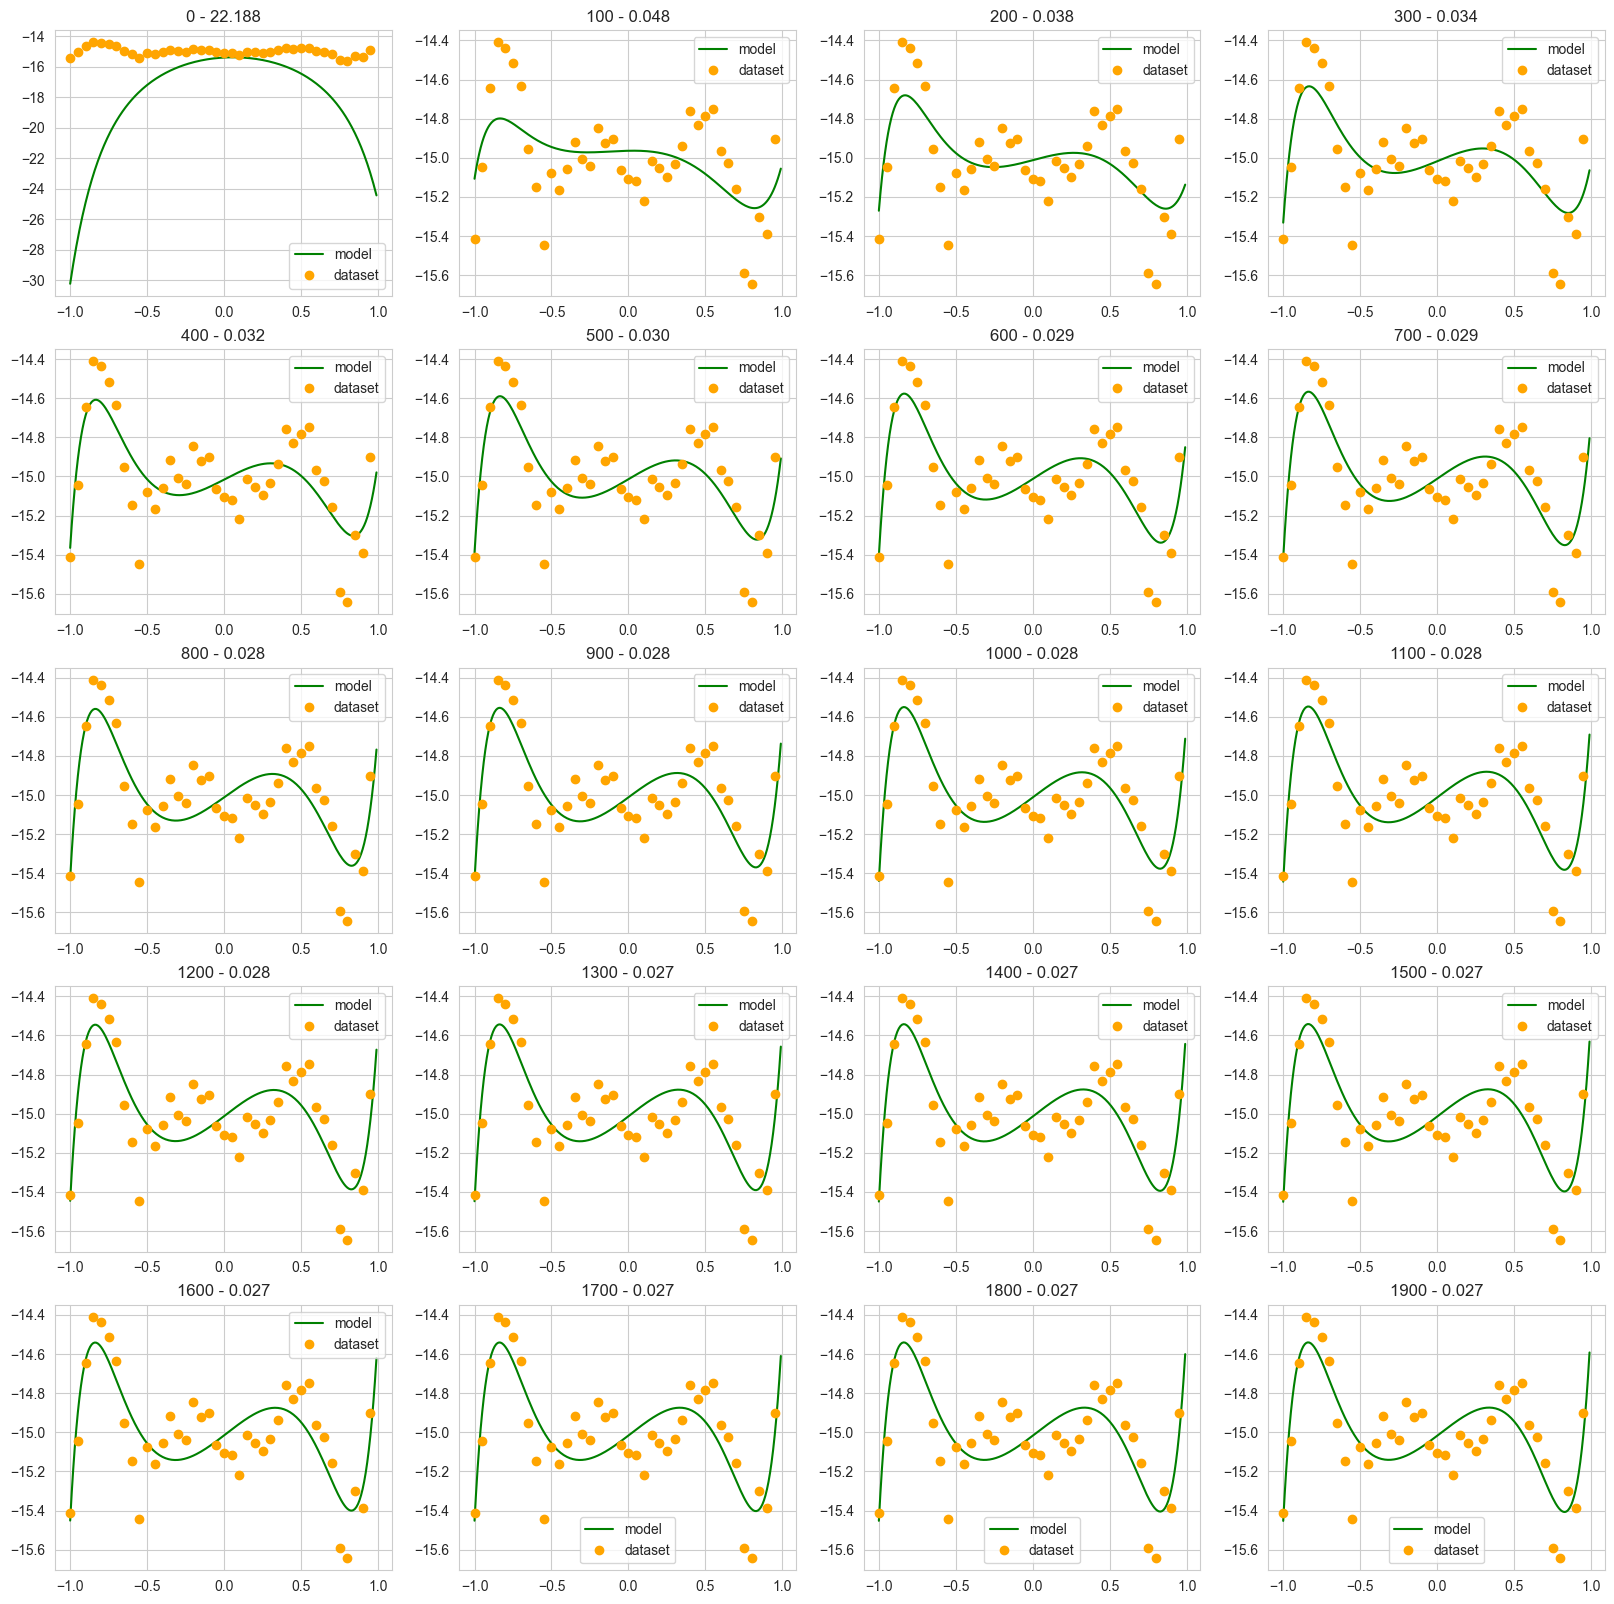

In [14]:

plt.figure(figsize=(20, 20))
for iter, epoch in enumerate(range(0, len(history), len(history) // 20)):
    h = history[epoch]
    model._coeffs = h[0]
    plt.subplot(5, 4, iter+1)
    plt.title(f"{epoch} - {h[1]:.3f}")
    plot(x, y, model_fn=model.forward)
plt.show()
